# A Hands-On Guide to Portfolio Optimization

## Introduction

The goal of this project is to implement the Markowitz portfolio optimization model. In a previous project, I detailed the mathematical theory behind the Markowitz model. This is a continuation of that project. This document is divided into three parts. In the first part, we quickly review the Markowitz model, we will implement the model in Python. Finally, we will use the model to optimize a portfolio of assets.

## Review of the Markowitz Model

The Markowitz portfolio optimization problem is formulated as follows (Kempthorne, 2013):

$$\begin{aligned}
& \underset{w}{\text{maximize}}
& & w^T R - \gamma w^T \Sigma w \\
& \text{subject to}
& & w^T \bf{1} = 1
\end{aligned}$$

where $w$ is a vector of weights, $R$ is a vector of expected returns, $\Sigma$ is a covariance matrix and $\gamma \geq 0$ is a risk aversion parameter.

## Implementation

### Optimization Library

We will be using `scipy.optimize.minimize` to solve the optimization problem (scipy does not have a maximization function). This function takes as input the objective function, the initial guess, a list of ranges for each variable, and the constraints for each variable. It can also take an optional `method` parameter, whicch is the specific optimization solver to use. By default, if no solver is specified, the function will use Broyden-Fletcher-Goldfarb-Shanno (BFGS) for unconstrained problems, SLSQP (Sequential Least Squares Quadratic Programming) for constrained problems and L-BFGS-B (Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Bounds) for bound-constrained problems (SciPy). We will be doing a bound-constrained optimization, so SciPy will use the L-BFGS-B method. Below is an explanation of how these solvers work. There are other solvers available, which we will not discuss in this paper.

**BFGS**: BFSG is an iterative optimization algorithm for unconstrained nonlinear problems that efficiently finds the minimum of a smooth, scalar-valued function by approximating the inverse Hessian matrix. It iteratively updates the approximation, determining search directions, and performs line searches to converge rapidly toward the optimal solution without requiring second-order derivatives.

**SLSQP**: SLSQP is a sequential least squares programming algorithm for nonlinearly constrained optimization. It solves the problem by iteratively solving a sequence of quadratic subproblems, which approximates the original problem. It uses the gradient and Hessian of the objective function and the gradients of the constraints to determine the search direction.

**L-BFGS-B**: L-BFGS-B is similar to BFGS, but it puts constraints on the variables.

### The Markowitz Function

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as spo

The `markowitz` takes as input a vector of returns and a gamma parameter. It computes the covariance matrix and the average return for each asset. We then define the objective function, which would be the minimum of the negative of the objective function defined above. Then we set the inital weights of each asset to be equal and we set the bounds for each weight to be between 0 and 1. For the constraints, we setv `type` to be `eq` for equality and `fun` to be a function that when equal to 0, the constraint is satisfied. Finally we solve!

In [5]:
def markowitz(returns, gamma):
    cov = returns.cov()
    mean = returns.mean()
    n = len(mean)

    f = lambda w: gamma * np.dot(np.dot(w, cov), w) - np.dot(w, mean)

    w0 = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]
    constraints = [{'type': 'eq', 'fun': lambda w: sum(w) - 1}]
    res = spo.minimize(f, w0, bounds=bounds, constraints=constraints)
    return np.round(res.x, 2)

## Usage

### Data

Using the `yfinance` library, we can download asset price data from Yahoo Finance. Using the function `yf.download(tickers, start, end)` (yfinance), we can download the price data for a list of tickers from a start date to an end date. The function returns a pandas dataframe with the price data. I have pre-collected a dataset asset returns per month for 10 assets. One of which (the 3 month T-Bill) is a cash equivalent asset. There is also the S&P 500. This is a asset which tracks the 500 largest companies in the US. It is a good proxy for the US stock market. Other 8 are assets which track the performance of various industries in the US.

**Assets**
- 3 Month T-Bill
- Consumer Discretionaries
- Health
- Tele-communications
- Finance
- Utilities
- S&P 500
- Consumer Staples
- Materials
- Information Technology
- Energy

Below is the pandas dataframe of the price change data for each asset.

In [3]:
df = pd.read_csv('./spsector.csv', index_col=0)
df.head()

,t bill 3mo,consumer discretionaries,health,tele communications,finance,utilities,s&p 500,consumer staples,materials,info tech,energy
date,,,,,,,,,,,
19990101,0.0436,0.062901,0.003816,0.095310,0.016585,-0.046136,0.041009,-0.015036,-0.029418,0.158504,-0.079363
19990201,0.0455,0.003263,0.005552,-0.027472,0.028204,-0.025584,-0.032283,-0.031827,-0.000312,-0.120723,-0.006375
19990301,0.0436,0.043225,0.026045,-0.006350,0.026524,-0.012413,0.038794,-0.016764,0.025186,0.091734,0.164443
19990401,0.0443,0.022983,-0.070525,0.022868,0.066651,0.072313,0.037944,0.013889,0.229507,-0.005706,0.155049
19990501,0.0451,-0.063519,-0.044478,0.005845,-0.068291,0.043578,-0.024970,-0.016008,-0.102145,-0.014789,-0.055582


### Example

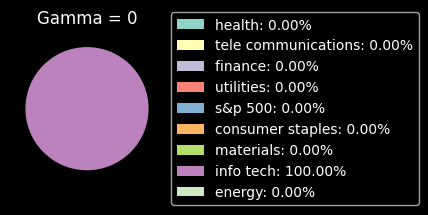

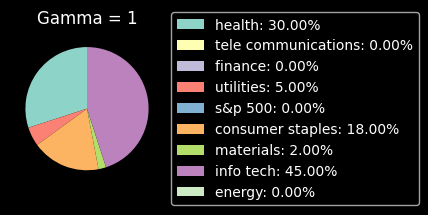

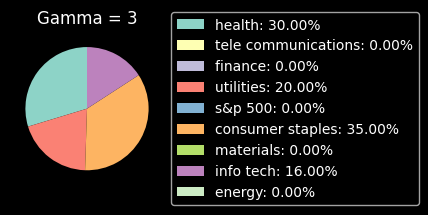

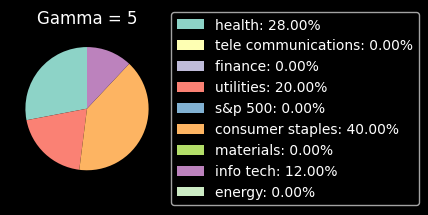

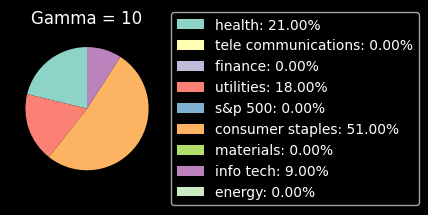

In [6]:
df = df.iloc[:, 1:]
asset_names = df.columns

gammas = [0, 1, 3, 5, 10]

for gamma in gammas:
    weights = markowitz(df, gamma)

    plt.figure(figsize=(2, 2))
    patches, texts, autotexts = plt.pie(weights, autopct='', startangle=90)
    plt.legend(patches, [f'{asset}: {weight:.2%}' for asset, weight in zip(asset_names, weights)], loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.xticks([])
    plt.yticks([])
    plt.title('Gamma = {}'.format(gamma))
    plt.show()

## References

* Kempthorne, P. (2013). Lecture 14: Portfolio Theory, MIT 18.S096. Topics In Mathematics With Applications In Finance. [https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/bba02164ba6642f7d516df35347aec01_MIT18_S096F13_lecnote14.pdf](https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/bba02164ba6642f7d516df35347aec01_MIT18_S096F13_lecnote14.pdf)

* SciPy. (n.d.). scipy.optimize.minimize. [https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

* yfinance (n.d.). yfinance. [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/)

* Nelder, J. A., & Mead, R. (1965). A Simplex Method for Function Minimization. The Computer Journal, 7(4), 308–313. https://doi.org/10.1093/comjnl/7.4.308